# 프로젝트 : 개선된 U-Net 모델 만들기
---
|평가문항|상세기준|
|:--|:--|
|1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?|	KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.|
|2. U-Net++ 모델이 성공적으로 구현되었는가?|	U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.|
|3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?|	U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.|

In [3]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

---
## Step 1. KITTI 데이터셋 수집과 구축
다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축

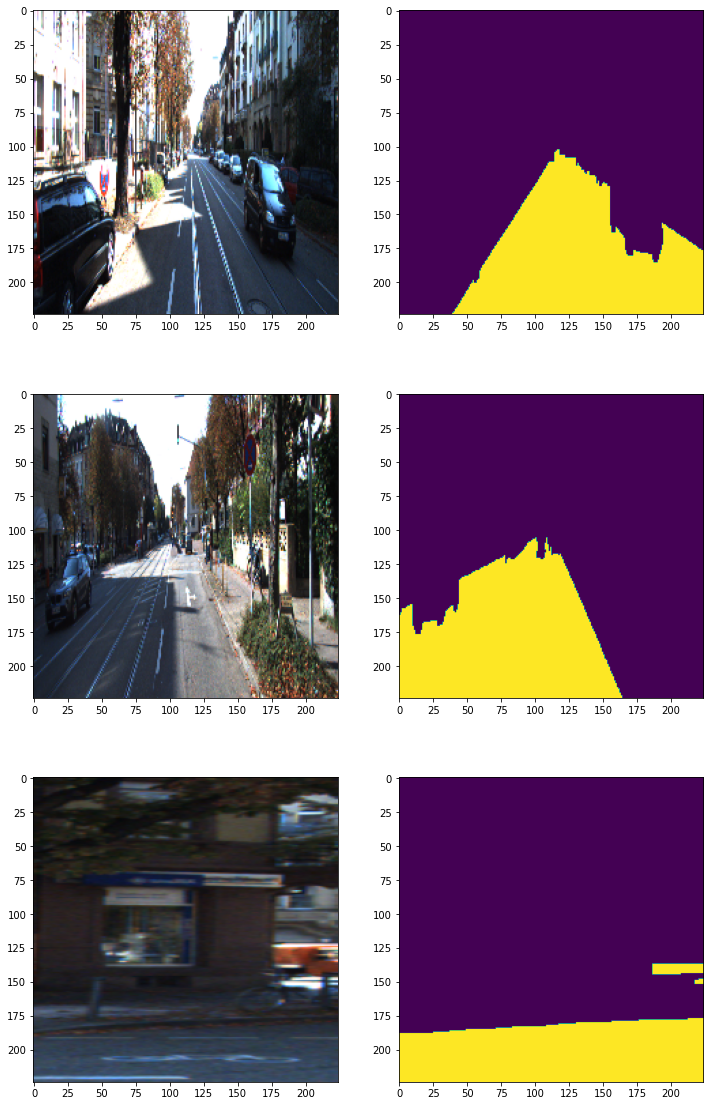

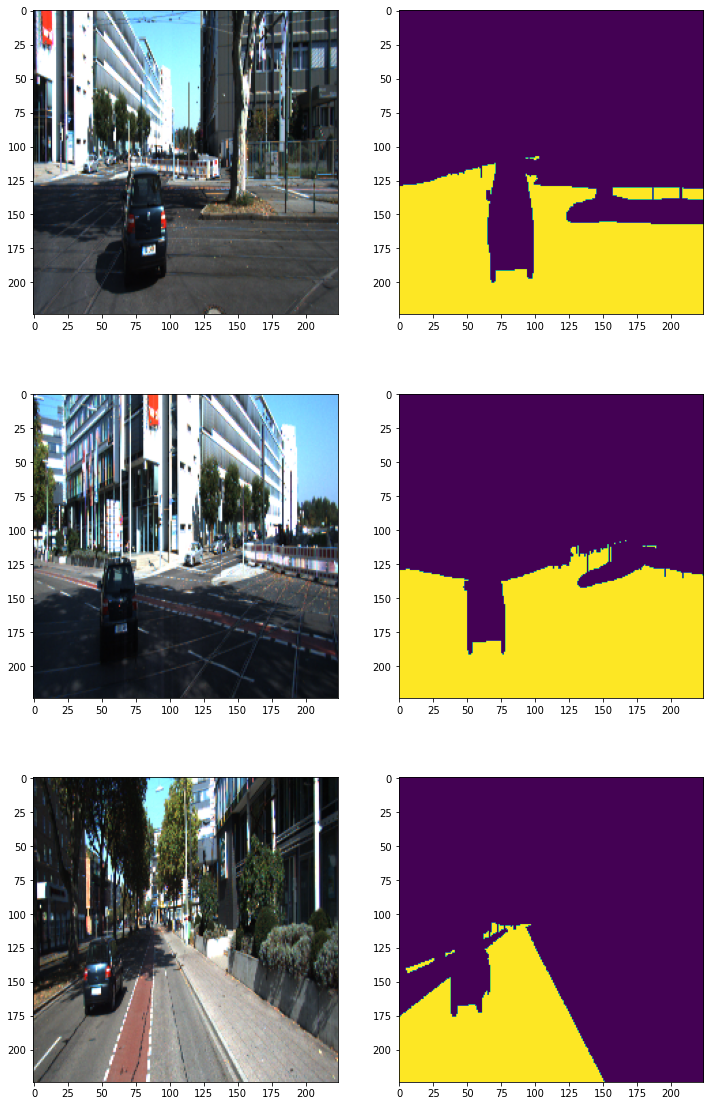

In [73]:
###################################################################################
# image augmentation
###################################################################################
def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
            RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(              # 입력이미지를 224X224로 resize
                width=224,
                height=224
            )
        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
        Resize(
            width=224,
            height=224
        )
    ])

###################################################################################
# 데이터 Generator
###################################################################################
class KittiGenerator(tf.keras.utils.Sequence):    
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''    
    def __init__(self, 
                 dir_path,
                 batch_size=8,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):        
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
        
    def __len__(self):
        # Generator의 전체 길이를 반환 함수 
        # 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 "올림"한 값 반환
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # index값에 따라 데이터를 반환하는 함수
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        return self.indexes

###################################################################################
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_preproc = build_augmentation(is_train=False)
test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

def show_data(generator, show_num=3):
    inputs, outputs = generator.__getitem__(0)
    plt.figure(figsize=(12, 20))
    for i in range(show_num):
        plt.subplot(show_num, 2, 2*i+1)
        plt.imshow(inputs[i] )
        plt.subplot(show_num, 2, 2*i+2)
        plt.imshow(outputs[i])
    plt.show()
show_data(train_generator)
show_data(test_generator)

---
## Step 2. U-Net++ 모델의 구현
기존 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델  

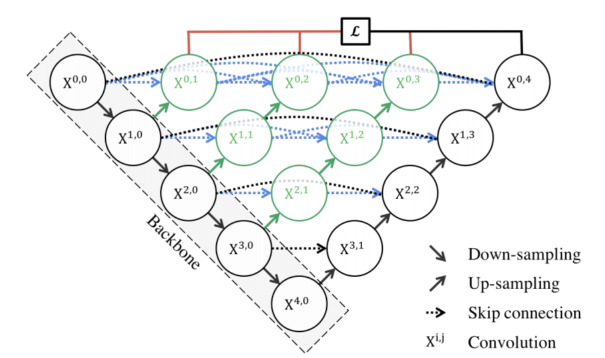  
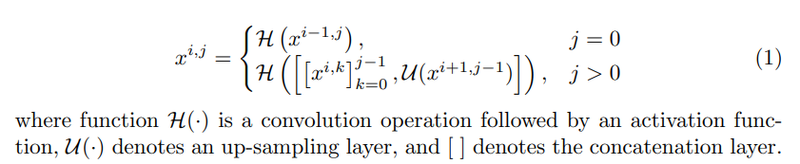  

### Loss를 조금 다르게 구현해야 한다  
binary cross-entropy와 dice coefficient를 사용  

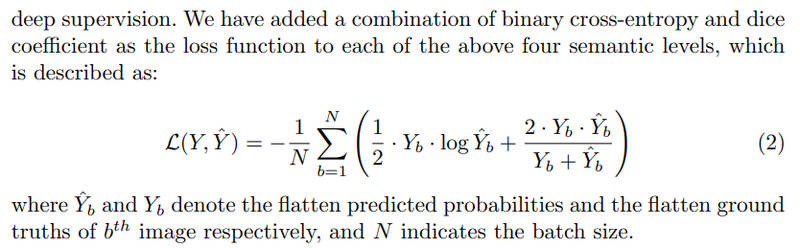  

In [8]:
#########################################################################################
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def down_sampling(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    x = conv_block(x, num_filters)
    return x, MaxPooling2D((2, 2))(x)

def up_sampling(inputs, skips, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = Concatenate()(skips + [x])
    x = conv_block(x, num_filters)
    return conv_block(x, num_filters)
#########################################################################################
# build_model
#########################################################################################
def build_model(input_shape=(224, 224, 3), is_plus=False, deep_supervision=False):    
    fsize=[64,128,256,512,1024]
    
    inputs = Input(shape=input_shape)
    
    x00, x = down_sampling(inputs, fsize[0])
    x10, x = down_sampling(x, fsize[1])
    x20, x = down_sampling(x, fsize[2])
    x30, x = down_sampling(x, fsize[3])
    x40, x = down_sampling(x, fsize[4])
    
    model_name = 'U-Net'
    if is_plus:
        x01 = up_sampling(x10, [x00], fsize[0])
        x11 = up_sampling(x20, [x10], fsize[1])
        x21 = up_sampling(x30, [x20], fsize[2])
        x31 = up_sampling(x40, [x30], fsize[3])

        x02 = up_sampling(x11, [x00, x01], fsize[0])
        x12 = up_sampling(x21, [x10, x11], fsize[1])
        x22 = up_sampling(x31, [x20, x21], fsize[2])

        x03 = up_sampling(x12, [x00, x01, x02], fsize[0])
        x13 = up_sampling(x22, [x10, x11, x12], fsize[1])

        x04 = up_sampling(x13, [x00, x01, x02, x03], fsize[0])
        
        x1 = Conv2D(1, 1, padding='same', activation='sigmoid')(x01)
        x2 = Conv2D(1, 1, padding='same', activation='sigmoid')(x02)
        x3 = Conv2D(1, 1, padding='same', activation='sigmoid')(x03)
        x4 = Conv2D(1, 1, padding='same', activation='sigmoid')(x04)
        
        if deep_supervision:
            x = [x1, x2, x3, x4]
            model_name='U-Net_Plus_Deep_Supervision'
        else:
            x = [x4]
            model_name='U-Net_Plus'
        
    else:
        x31 = up_sampling(x40, [x30], fsize[3])
        x22 = up_sampling(x31, [x20], fsize[2])
        x13 = up_sampling(x22, [x10], fsize[1])
        x04 = up_sampling(x13, [x00], fsize[0])        
        x = Conv2D(1, 1, padding='same', activation='sigmoid')(x04)
       
    return Model(inputs=inputs, outputs=x, name=model_name)
    
    
#########################################################################################
# 모델 컴파일
#########################################################################################
from tensorflow.keras import backend

# Dice Coefficient
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = backend.flatten(y_true)
    y_pred_f = backend.flatten(y_pred)
    intersection = backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=bce_dice_loss,
        metrics=["binary_crossentropy", dice_coef]
    )
    model.summary()
    return model;
#########################################################################################
# 모델 훈련
#########################################################################################
import pickle
def fit_model(model):
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        steps_per_epoch=len(train_generator),
        epochs=100
    )    
    m_path = f'./model_{model.name}.h5'
    model.save(m_path)  #학습한 모델을 저장

    h_path = f'./history_{model.name}.pkl'
    with open(h_path, 'wb') as file:
        pickle.dump(history.history, file)
    return model, history

### U-Net 모델 학습

In [9]:
m1 = compile_model(build_model())
m1, h_m1 = fit_model(m1)

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 224, 224, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 224, 224, 64) 0           batch_normalization_18[0][0]     
______________________________________________________________________________________________

### U-Net ++ 모델 학습

In [10]:
m2 = compile_model(build_model(is_plus=True))
m2, h_m2 = fit_model(m2)

Model: "U-Net_Plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 224, 224, 64) 256         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 224, 224, 64) 0           batch_normalization_36[0][0]     
_________________________________________________________________________________________

### U-Net ++ Deep Supervision모델 학습

In [11]:
m3 = compile_model(build_model(is_plus=True, deep_supervision=True))
m3, h_m3 = fit_model(m3)

Model: "U-Net_Plus_Deep_Supervision"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_66 (BatchNo (None, 224, 224, 64) 256         conv2d_72[0][0]                  
__________________________________________________________________________________________________
activation_66 (Activation)      (None, 224, 224, 64) 0           batch_normalization_66[0][0]     
________________________________________________________________________

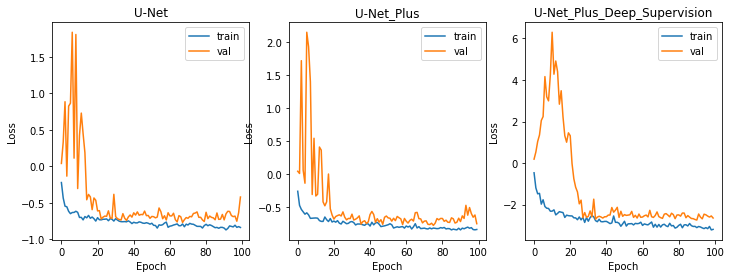

In [12]:
plt.figure(figsize=(12, 4))

# train, validation loss graph
plt.subplot(1, 3, 1)
plt.plot(h_m1.history['loss'])
plt.plot(h_m1.history['val_loss'])
plt.title(f'{m1.name}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 3, 2)
plt.plot(h_m2.history['loss'])
plt.plot(h_m2.history['val_loss'])
plt.title(f'{m2.name}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 3, 3)
plt.plot(h_m3.history['loss'])
plt.plot(h_m3.history['val_loss'])
plt.title(f'{m3.name}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

---
### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

#### 시각화 비교
입력 이미지와 라벨을 한 번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 오버레이(overray)  

#### IoU 계산 비교
모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, 
그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬
각각을 prediction, target이라고 불렀을 때 이를 계산하는 함수를 구현

In [91]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    if np.ndim(output) > 2:
        output = np.mean(output, axis=0) # 평균값
        
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.7)
#     output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역
        
        def calculate_iou_score(target, prediction):
            intersection = np.logical_and(target, prediction)
            union = np.logical_or(target, prediction)
            iou_score = tf.cast(np.sum(intersection) / np.sum(union), tf.float32)

            return iou_score

        iou_score = calculate_iou_score(target, prediction)
        
        return output, iou_score
    else:
        return output, 0


def show_output(img_num):
    i = img_num 
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png'
    output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
    label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    
    output1, iou1 = get_output(m1, test_preproc, image_path, output_path, label_path)
    output2, iou2 = get_output(m2, test_preproc, image_path, output_path, label_path)
    output3, iou3 = get_output(m3, test_preproc, image_path, output_path, label_path)

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.title(f'{m1.name}')
    plt.xlabel(f'IoU : {iou1}')
    plt.imshow(output1)

    plt.subplot(1, 3, 2)
    plt.title(f'{m2.name}')
    plt.xlabel(f'IoU : {iou2}')
    plt.imshow(output2)

    plt.subplot(1, 3, 3)
    plt.title(f'{m3.name}')
    plt.xlabel(f'IoU : {iou3}')
    plt.imshow(output3)

    plt.show()

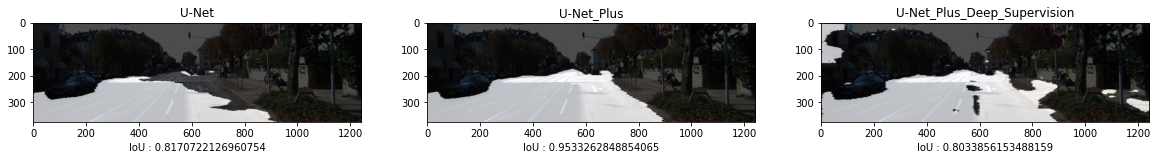

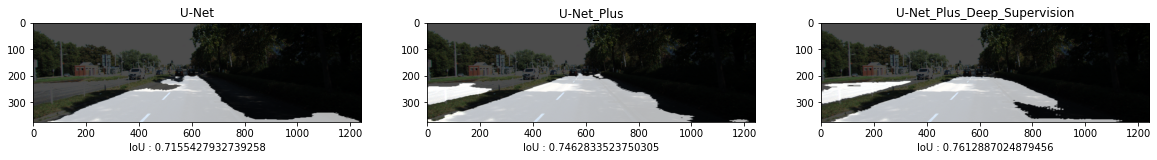

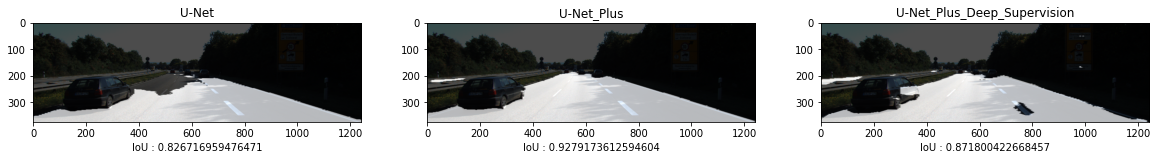

In [92]:
show_output(1)
show_output(30)
show_output(100)

---
## 회고
---
일반적으로 U-Net++ 모델이 U-Net 모델보다 좋은 성능을 보여준다  
U-Net++ 모델에 Deep Supervision 적용시에는 시각화 이미지 상으로는 적용하지 않은 모델 보다 디테일하게 검출하는 것으로 보이지만,  
그 결과 label mask와 겹치는 영역이 줄어 IoU 계산 값은 더 낮게 계산되는 경우가 많은 것 같다.

U-Net++ 모델의 구조를 보면서 Down Sampling 과 여러 잔차 연결을 통한 Up Sampling 구조를 구현해보면서 모델 구조를 구현하는 코드에 좀 더 익숙해 진 것 같다.